In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
sns.set()

In [2]:
client = bigquery.Client()

query=f"""
SELECT DATE, GKGRECORDID, DocumentIdentifier
FROM goldenfleece.final_task.gkg_daily_mail_v2
order by DATE
"""
url_df = client.query(query).to_dataframe()
url_df.head()

,DATE,GKGRECORDID,DocumentIdentifier
0,2015-03-01,20150301010000-1308,http://www.dailymail.co.uk/money/markets/article-2973645/Investors-fear-post-election-chaos-believe-politicians-not-support-reveals-survey.html
1,2015-03-01,20150301010000-572,http://www.dailymail.co.uk/money/markets/article-2973635/Future-looks-healthy-Foods-sales-exceed-100m.html
2,2015-03-01,20150301010000-1311,http://www.dailymail.co.uk/money/markets/article-2973550/ITV-reveal-turnaround-s-success-profits-22.html
3,2015-03-01,20150301010000-1303,http://www.dailymail.co.uk/money/markets/article-2973619/Trinity-Mirror-set-reveal-fall-profits.html
4,2015-03-02,20150302234500-1894,http://www.dailymail.co.uk/money/markets/article-2976383/Barclays-braced-huge-penalties-stows-extra-500m-pay-fines-rigging-foreign-currency-rates.html


In [3]:
url_df = url_df.astype({"DATE":"datetime64"}).set_index("DATE")
url_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17257 entries, 2015-03-01 to 2020-09-30
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GKGRECORDID         17257 non-null  object
 1   DocumentIdentifier  17257 non-null  object
dtypes: object(2)
memory usage: 404.5+ KB


<AxesSubplot:xlabel='DATE'>

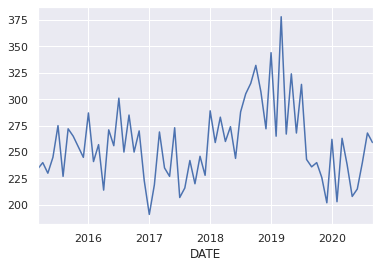

In [4]:
url_df.resample("MS")["GKGRECORDID"].count().plot()

In [5]:
print(f"Total URLs to retrive: {len(url_df)}")
url_df.resample("AS")["GKGRECORDID"].count()

Total URLs to retrive: 17257


DATE
2015-01-01    2488
2016-01-01    3105
2017-01-01    2773
2018-01-01    3428
2019-01-01    3307
2020-01-01    2156
Freq: AS-JAN, Name: GKGRECORDID, dtype: int64

### start with 2015 first

In [6]:
from web_scraper import get_articles

In [7]:
def get_articles_by_year(url_df, year):
    year = str(year)
    # filter by year
    url_df_subset = url_df.loc[year]
    
    # convert series to list
    url_list = url_df_subset["DocumentIdentifier"].to_list()
    
    # this will return list of 2-tuple
    articles = get_articles(url_list)
    assert len(url_list) == len(articles)
    
    return articles

In [42]:
articles = get_articles_by_year(url_df, 2020)

Processing a total of 2156 articles


In [43]:
url_df_subset = url_df.loc["2020"]
url_list = url_df_subset["DocumentIdentifier"].to_list()

In [44]:
url_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2156 entries, 2020-01-01 to 2020-09-30
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GKGRECORDID         2156 non-null   object
 1   DocumentIdentifier  2156 non-null   object
dtypes: object(2)
memory usage: 50.5+ KB


In [45]:
# merge with url_df_subset and store the output to Google Big Query
url_df_subset[['title', 'content']] = pd.DataFrame(articles, index=url_df_subset.index) 

In [46]:
url_df_subset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2156 entries, 2020-01-01 to 2020-09-30
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GKGRECORDID         2156 non-null   object
 1   DocumentIdentifier  2156 non-null   object
 2   title               2156 non-null   object
 3   content             2156 non-null   object
dtypes: object(4)
memory usage: 9.2 MB


In [47]:
empty_content = url_df_subset[url_df_subset.content == ""]

print(f"Number of articles with empty content: {len(empty_content)}")

empty_content

Number of articles with empty content: 1


,GKGRECORDID,DocumentIdentifier,title,content
DATE,,,,
2020-01-06,20200106100000-387,https://www.dailymail.co.uk/money/markets/article-7856005/FTSE-Live-Car-registrations-lowest-level-6-years-Aldi-boasts-bumper-Christmas.html,FTSE CLOSE: Car registrations at lowest level in six years; Aldi boasts bumper Christmas; Services sector stagnates in December,


In [48]:
url_df_subset.to_gbq("final_task.daily_mail_2015", project_id="goldenfleece", if_exists="append")

1it [00:06,  6.64s/it]
